# Time-Series MIA Example 

In [1]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, random

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import preprocess_ECG_dataset, preprocess_EEG_dataset, preprocess_LCL_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata, evaluate
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.TimesNet import TimesNet
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.TFT import TFT
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet

In [2]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [3]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"]

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
dataset = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use (applicable for EEG only)

In [4]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [5]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_file = audit_config["target"]["data_path"].split('/')[-1]

if dataset == 'ECG' and target_data_file == 'ECG.pkl':
    dataset = preprocess_ECG_dataset(path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)
elif dataset == 'EEG' and target_data_file == 'EEG.pkl':
    dataset = preprocess_EEG_dataset(path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)
elif dataset == 'LCL' and target_data_file == 'LCL.pkl':
    dataset = preprocess_LCL_dataset(path, lookback, horizon, num_individuals, stride=stride)
else:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset}, target={target_data_file}.")

train_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

Save data to c:\Users\totte\Documents\Kurser\DATX05 - Master's Thesis\LeakPro\examples\mia\time_series_mia\data/LCL.pkl


In [6]:
# Train the model
input_dim = dataset.input_dim
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "TimesNet":
    model = TimesNet(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "TFT":
    model = TFT(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs, optimizer)

Training Progress: 100%|██████████| 100/100 [07:59<00:00,  4.79s/it]


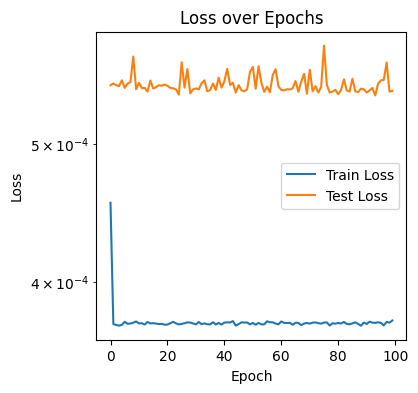

In [7]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [8]:
# Print final loss and unscaled MSE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train MSE (unscaled): {evaluate(model, train_loader, torch.nn.MSELoss(), device, original_scale=True)}')
print(f'Final test MSE (unscaled): {evaluate(model, test_loader, torch.nn.MSELoss(), device, original_scale=True)}')

Final train loss: 0.0003756280411364125
Final test loss: 0.0005445869849308403
Final train MSE (unscaled): 0.006421281849151628
Final test MSE (unscaled): 0.009437435894656789


### Plotting sample predictions

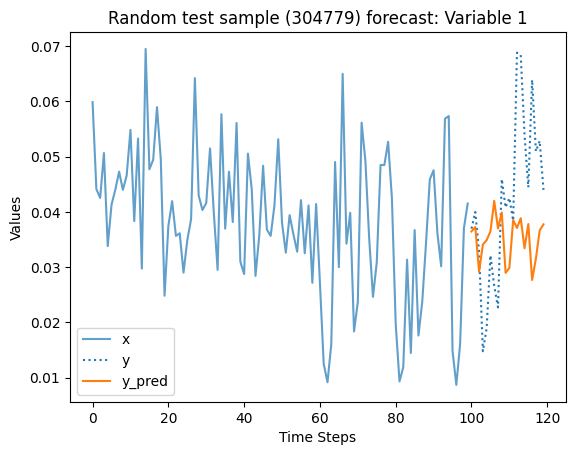

In [9]:
# Get random sample (re-execute for new one)
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.x[random_sample_idx,:,:].to(device)
y = dataset.y[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i].cpu().numpy(), label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i].cpu().numpy(), label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

### Running MIA

In [ ]:
from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
leakpro.run_audit()

2025-03-04 18:10:06,762 INFO     Target model blueprint created from DLinear in ./utils/models/DLinear.py.
2025-03-04 18:10:06,777 INFO     Loaded target model metadata from ./target/model_metadata.pkl
c:\Users\totte\Documents\Kurser\DATX05 - Master's Thesis\LeakPro\leakpro\input_handler\handler_setup.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se

{'audit': {'random_seed': 42, 'attack_list': {'ensemble': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_instances': 50, 'subset_size': 50, 'num_pairs': 5, 'audit': True}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/DLinear.py', 'model_class': 'DLinear', 'target_folder': './target', 'data_path': './data/LCL.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-03-04 18:10:06,995 INFO     Loaded population dataset from ./data/LCL.pkl
2025-03-04 18:10:06,996 INFO     Loaded population dataset from ./data/LCL.pkl
2025-03-04 18:10:08,816 INFO     MIA attack factory loaded.
2025-03-04 18:10:08,816 INFO     Creating shadow model handler singleton
2025-03-04 18:10:08,818 INFO     Creating distillation model handler singleton
2025-03-04 18:10:08,820 INFO     Configuring Ensemble attack
2025-03-04 18:10:08,821 INFO     Added attack: ensemble
2025-03-04 18:10:08,822 INFO     Preparing attack: ensemble
2025-03-04 18:10:08,823 INFO     Preparing shadow models for Ensemble attack
2025-03-04 18:10:08,824 INFO     Preparing attack data for training the Ensemble attack
2025-03-04 18:10:08,852 INFO     self.attack_data_indices=array([318996, 254063, 307028, ...,  92743,  70682,  13315])
2025-03-04 18:10:08,855 INFO     Running attack: ensemble
2025-03-04 18:10:08,856 INFO     Running Ensemble shadow attack (audit mode)
2025-03-04 18:10:08,858 INFO     R